In [57]:
import gpytorch
import torch
import math
import matplotlib.pyplot as plt
from torchcubicspline import natural_cubic_spline_coeffs, NaturalCubicSpline

In [58]:
train_x = torch.linspace(0, 1, 100)[torch.randint(0,100, (5,))]
def f(x):
    return torch.sin(x * (2 * math.pi))
train_y = f(train_x) + torch.randn(train_x.size()) * math.sqrt(0.04)
test_x = torch.linspace(0, 1, 51)

mean_x = torch.linspace(0, 1, 51) 
mean_y = f(mean_x)

In [59]:
class FixedMean(gpytorch.means.Mean):
    def __init__(self, mean_x, mean_y):
        super().__init__()
        coeffs = natural_cubic_spline_coeffs(mean_x, mean_y.reshape(-1,1))
        self.spline = NaturalCubicSpline(coeffs)

    def forward(self, x):
        return self.spline.evaluate(x).squeeze()
    
mean_module = FixedMean(mean_x, mean_y)

In [60]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = mean_module
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [61]:
training_iterations = 100

# Find optimal model hyperparameters
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1) 
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    if i%10==0:
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))

Iter 1/100 - Loss: 1.001
Iter 11/100 - Loss: 0.622
Iter 21/100 - Loss: 0.288
Iter 31/100 - Loss: 0.134
Iter 41/100 - Loss: 0.093
Iter 51/100 - Loss: 0.053
Iter 61/100 - Loss: 0.043
Iter 71/100 - Loss: 0.037
Iter 81/100 - Loss: 0.034
Iter 91/100 - Loss: 0.033


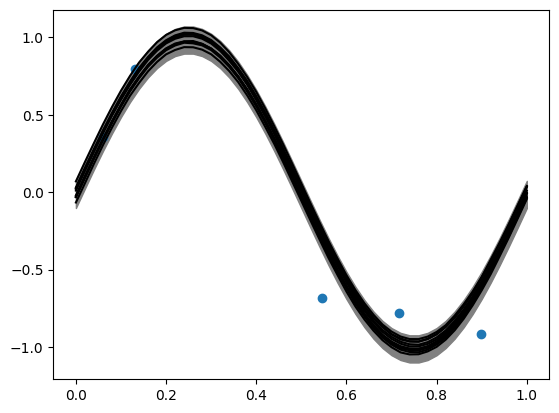

In [62]:
model.eval()
likelihood.eval()

@torch.no_grad()
def plot_samples_1d(ax, dist, num_samples):
    lower, upper = dist.confidence_region()
    for _ in range(num_samples):
        z_sample = dist.sample()
        ax.plot(test_x, z_sample, color="k")
    
    ax.fill_between(test_x, lower.numpy(), upper.numpy(), color="grey")
    
    return 

fig, ax = plt.subplots()
posterior = model(test_x)
plot_samples_1d(ax, posterior, 10)
ax.scatter(train_x, train_y)
plt.show()